## **Does the Home Run Derby Affect a Batter's Swing?**

The first project in a five-part 60-Day Baseball Analytics Challenge
<br>
By: [Samantha Nadler](mailto:nadler.2004@gmail.com)

### **Project Overview**

The night before the MLB All-Star Game, eight of the league's greatest power hitters come together for an evening of hitting exciting home runs in hopes of winning the Derby and taking home $500,000 and a chain. However, baseball writers like to make the argument that participating in the Home Run Derby, an event that is designed for batters to see easy pitches and hit them at high power, harms their swing in the second half of the MLB season.

This project looks at the performances of the eight participants in the 2024 Home Run Derby before and after the All-Star break.

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Python packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
# Read the main .csv file
# Only focus on regular-season games

MLB_2024 = pd.read_csv('/content/drive/MyDrive/60_day_baseball_analytics_challenge/MLB_2024.csv')
MLB_2024 = MLB_2024[MLB_2024['game_type'] == 'R']

MLB_2024.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,1.32,0.85,-0.85,19.4
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,3,2,5.0,1.0,6.0,1.0,2.82,1.40,-1.40,14.4
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,3,2,5.0,1.0,6.0,1.0,2.37,1.48,-1.48,21.9
3,KC,2024-04-02,80.8,-3.13,5.61,"Rizzo, Anthony",519203,668678,field_out,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,4.61,-0.50,0.50,36.3
4,FF,2024-04-02,95.4,-1.95,5.12,"Hedges, Austin",595978,622491,strikeout,foul_tip,...,3,2,5.0,3.0,6.0,6.0,1.59,1.08,1.08,17.5


The following variables were used. Data comes from 2024 MLB Statcast data.

- `game_date` (to split the season data into two halves)
- `player_name` and `batter` (to identify each batter - `player_name` is a String object while `batter` is a numerical ID)
- `events` and `bb_type` (to categorize and analyze trends of events that end at-bats)
- `balls` and `strikes` (to determine final counts in at-bats, determining any shifts in plate discipline pre-Derby and post-Derby)
- `pitch_number` (to determine plate discipline - a player may hit multiple foul balls with 2 strikes and not change the count)
- `launch_speed` and `launch_angle` (to determine any kinematic shifts in each batter's swing - **for in-play balls only**)

A new variable, `count`, was created by concatenating the number of balls and strikes at the end of the batters' at-bats. Additionally, only regular-season games were considered into batters' swings, as denoted by an **R** in the variable `game_type`.

In [ ]:
# Choose columns for the DataFrames

MLB_2024 = MLB_2024[['game_date', 'player_name', 'batter', 'events', 'bb_type', 'balls', 'strikes', 'pitch_number', 'launch_speed', 'launch_angle']]
MLB_2024['count'] = MLB_2024['balls'].astype(str) + '-' + MLB_2024['strikes'].astype(str)
MLB_2024.rename(columns = {'game_date': 'date', 'bb_type': 'hit_type', 'pitch_number': 'pitch_count', 'launch_speed': 'exit_velocity'}, inplace = True)

MLB_2024.head()

,date,player_name,batter,events,hit_type,balls,strikes,pitch_count,exit_velocity,launch_angle,count
0,2024-04-02,"Rocchio, Brayan",677587,single,popup,0,2,3,61.9,28.0,0-2
1,2024-04-02,"Rocchio, Brayan",677587,NaN,NaN,0,1,2,69.0,-38.0,0-1
2,2024-04-02,"Rocchio, Brayan",677587,NaN,NaN,0,0,1,NaN,NaN,0-0
3,2024-04-02,"Rizzo, Anthony",519203,field_out,ground_ball,3,2,6,31.7,-62.0,3-2
4,2024-04-02,"Hedges, Austin",595978,strikeout,NaN,1,2,4,NaN,NaN,1-2


In [ ]:
# Data Cleaning
# Only focus on events that ended at-bats (events is not null)

MLB_2024 = MLB_2024[~MLB_2024['events'].isna()]


# Define variables to keep track of hits

events = pd.get_dummies(MLB_2024['events'], dtype = int)
MLB_2024 = pd.concat([MLB_2024, events], axis = 1)
MLB_2024['ab'] = np.where(MLB_2024['events'].str.contains('walk|hit_by_pitch|sac_bunt|sac_fly|sac_fly_double_play|catcher_interf|truncated_pa'), 0, 1)
MLB_2024['pa'] = np.where(MLB_2024['events'].str.contains('truncated_pa'), 0, 1)

MLB_2024.head()

,date,player_name,batter,events,hit_type,balls,strikes,pitch_count,exit_velocity,launch_angle,...,sac_fly_double_play,single,strikeout,strikeout_double_play,triple,triple_play,truncated_pa,walk,ab,pa
0,2024-04-02,"Rocchio, Brayan",677587,single,popup,0,2,3,61.9,28.0,...,0,1,0,0,0,0,0,0,1,1
3,2024-04-02,"Rizzo, Anthony",519203,field_out,ground_ball,3,2,6,31.7,-62.0,...,0,0,0,0,0,0,0,0,1,1
4,2024-04-02,"Hedges, Austin",595978,strikeout,NaN,1,2,4,NaN,NaN,...,0,0,1,0,0,0,0,0,1,1
5,2024-04-02,"Ohtani, Shohei",660271,walk,NaN,3,0,4,NaN,NaN,...,0,0,0,0,0,0,0,1,0,1
6,2024-04-02,"Casas, Triston",671213,walk,NaN,3,2,8,NaN,NaN,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Split data into two halves (2024 All-Star break was July 15-18)

MLB_2024['date'] = pd.to_datetime(MLB_2024['date'])

MLB_2024_pre = MLB_2024[MLB_2024['date'] < '2024-07-15']
MLB_2024_post = MLB_2024[MLB_2024['date'] > '2024-07-18']

In [ ]:
# Create DataFrames for each batter
# Pre-All-Star break stats

Alonso_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 624413]
Bohm_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 664761]
Garcia_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 666969]
Henderson_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 683002]
Hernandez_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 606192]
Ozuna_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 542303]
Ramirez_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 608070]
Witt_pre = MLB_2024_pre[MLB_2024_pre['batter'] == 677951]

In [ ]:
# Create DataFrames for each batter
# Post-All-Star break stats

Alonso_post = MLB_2024_post[MLB_2024_post['batter'] == 624413]
Bohm_post = MLB_2024_post[MLB_2024_post['batter'] == 664761]
Garcia_post = MLB_2024_post[MLB_2024_post['batter'] == 666969]
Henderson_post = MLB_2024_post[MLB_2024_post['batter'] == 683002]
Hernandez_post = MLB_2024_post[MLB_2024_post['batter'] == 606192]
Ozuna_post = MLB_2024_post[MLB_2024_post['batter'] == 542303]
Ramirez_post = MLB_2024_post[MLB_2024_post['batter'] == 608070]
Witt_post = MLB_2024_post[MLB_2024_post['batter'] == 677951]

In [ ]:
# Concatenate the DataFrames

Alonso = pd.concat([Alonso_pre, Alonso_post])
Bohm = pd.concat([Bohm_pre, Bohm_post])
Garcia = pd.concat([Garcia_pre, Garcia_post])
Henderson = pd.concat([Henderson_pre, Henderson_post])
Hernandez = pd.concat([Hernandez_pre, Hernandez_post])
Ozuna = pd.concat([Ozuna_pre, Ozuna_post])
Ramirez = pd.concat([Ramirez_pre, Ramirez_post])
Witt = pd.concat([Witt_pre, Witt_post])

In [ ]:
# Create DataFrame containing at-bat data for all eight Home Run Derby participants

HRD_batters = [624413, 664761, 666969, 683002, 606192, 542303, 608070, 677951]

HRD_2024 = MLB_2024[MLB_2024['batter'].isin(HRD_batters)]
HRD_2024_pre = MLB_2024_pre[MLB_2024_pre['batter'].isin(HRD_batters)]
HRD_2024_post = MLB_2024_post[MLB_2024_post['batter'].isin(HRD_batters)]

HRD_2024

,date,player_name,batter,events,hit_type,balls,strikes,pitch_count,exit_velocity,launch_angle,...,sac_fly_double_play,single,strikeout,strikeout_double_play,triple,triple_play,truncated_pa,walk,ab,pa
83,2024-04-02,"Ozuna, Marcell",542303,home_run,fly_ball,0,0,1,98.9,42.0,...,0,0,0,0,0,0,0,0,1,1
228,2024-04-02,"Hernández, Teoscar",606192,walk,NaN,3,2,7,NaN,NaN,...,0,0,0,0,0,0,0,1,0,1
308,2024-04-02,"Ramírez, José",608070,field_out,ground_ball,1,0,2,97.1,-9.0,...,0,0,0,0,0,0,0,0,1,1
333,2024-04-02,"Bohm, Alec",664761,field_out,ground_ball,1,1,3,99.9,-19.0,...,0,0,0,0,0,0,0,0,1,1
375,2024-04-02,"García, Adolis",666969,double,ground_ball,1,1,3,96.2,-9.0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688588,2024-09-30,"Ozuna, Marcell",542303,walk,NaN,3,2,7,NaN,NaN,...,0,0,0,0,0,0,0,1,0,1
688639,2024-09-30,"Alonso, Pete",624413,field_out,ground_ball,0,0,1,70.9,-34.0,...,0,0,0,0,0,0,0,0,1,1
688691,2024-09-30,"Alonso, Pete",624413,strikeout,NaN,2,2,5,NaN,NaN,...,0,0,1,0,0,0,0,0,1,1
688702,2024-09-30,"Ozuna, Marcell",542303,field_out,fly_ball,0,0,1,96.3,34.0,...,0,0,0,0,0,0,0,0,1,1


### **Function definition for metric calculation and visualizations**

In [ ]:
# Delta_OPS (change in on-base plus slugging between two halves of the season)

def Delta_OPS(pre, post):
    OBP_pre = (pre['single'].sum() + pre['double'].sum() + pre['triple'].sum()+ pre['home_run'].sum() + pre['walk'].sum() + pre['hit_by_pitch'].sum()) / (pre['ab'].sum() + pre['walk'].sum() + pre['hit_by_pitch'].sum() + pre['sac_fly'].sum())
    OBP_post = (post['single'].sum() + post['double'].sum() + post['triple'].sum()+ post['home_run'].sum() + post['walk'].sum() + post['hit_by_pitch'].sum()) / (post['ab'].sum() + post['walk'].sum() + post['hit_by_pitch'].sum() + post['sac_fly'].sum())

    SLG_pre = ((pre['single'].sum() * 1) + (pre['double'].sum() * 2) + (pre['triple'].sum() * 3) + (pre['home_run'].sum() * 4)) / pre['ab'].sum()
    SLG_post = ((post['single'].sum() * 1) + (post['double'].sum() * 2) + (post['triple'].sum() * 3) + (post['home_run'].sum() * 4)) / post['ab'].sum()

    OPS_pre = OBP_pre + SLG_pre
    OPS_post = OBP_post + SLG_post

    return (OPS_post - OPS_pre) / OPS_pre

In [ ]:
# Delta_wOBA (change in weighted on-base average between two halves of the season)

def Delta_wOBA(pre, post):
    w1B = 0.882
    w2B = 1.254
    w3B = 1.590
    wHR = 2.050
    wBB = 0.689
    wHBP = 0.720

    wOBA_pre = ((pre['single'].sum() * w1B) + (pre['double'].sum() * w2B) + (pre['triple'].sum() * w3B) + (pre['home_run'].sum() * wHR) + (pre['walk'].sum() * wBB) + (pre['hit_by_pitch'].sum() * wHBP)) / (pre['ab'].sum() + pre['walk'].sum() + pre['hit_by_pitch'].sum() + pre['sac_fly'].sum())
    wOBA_post = ((post['single'].sum() * w1B) + (post['double'].sum() * w2B) + (post['triple'].sum() * w3B) + (post['home_run'].sum() * wHR) + (post['walk'].sum() * wBB) + (post['hit_by_pitch'].sum() * wHBP)) / (post['ab'].sum() + post['walk'].sum() + post['hit_by_pitch'].sum() + post['sac_fly'].sum())

    return (wOBA_post - wOBA_pre) / wOBA_pre

In [ ]:
# Delta_ISO (change in isolated power between two halves of the season)

def Delta_ISO(pre, post):
    ISO_pre = ((pre['double'].sum() * 1) + (pre['triple'].sum() * 2) + (pre['home_run'].sum() * 3)) / pre['ab'].sum()
    ISO_post = ((post['double'].sum() * 1) + (post['triple'].sum() * 2) + (post['home_run'].sum() * 3)) / post['ab'].sum()

    return (ISO_post - ISO_pre) / ISO_pre

In [ ]:
# PBPI (calculates the Post-Break Performance Index)

def PBPI(pre, post):
    w_OPS = 0.80
    w_wOBA = 1.00
    w_ISO = 0.60

    return 100 * ((Delta_OPS(pre, post) * w_OPS) + (Delta_wOBA(pre, post) * w_wOBA) + (Delta_ISO(pre, post) * w_ISO)) / (w_OPS + w_wOBA + w_ISO)

In [ ]:
# Determine PBPI for each Home Run Derby participant

print('PBPI for Pete Alonso:                 ', round(PBPI(Alonso_pre, Alonso_post), 2))
print('PBPI for Alec Bohm:                 ', round(PBPI(Bohm_pre, Bohm_post), 2))
print('PBPI for Adolis Garcia:              ', round(PBPI(Garcia_pre, Garcia_post), 2))
print('PBPI for Gunnar Henderson:          ', round(PBPI(Henderson_pre, Henderson_post), 2))
print('PBPI for Teoscar Hernandez:          ', round(PBPI(Hernandez_pre, Hernandez_post), 2))
print('PBPI for Marcell Ozuna:             ', round(PBPI(Ozuna_pre, Ozuna_post), 2))
print('PBPI for Jose Ramirez:                ', round(PBPI(Ramirez_pre, Ramirez_post), 2))
print('PBPI for Bobby Witt Jr.:             ', round(PBPI(Witt_pre, Witt_post), 2))

print('-------------------------------------------')

print('Overall PBPI for the above batters:  ', round(PBPI(HRD_2024_pre, HRD_2024_post), 2))

PBPI for Pete Alonso:                  5.69
PBPI for Alec Bohm:                  -20.63
PBPI for Adolis Garcia:               -0.62
PBPI for Gunnar Henderson:           -21.07
PBPI for Teoscar Hernandez:           18.95
PBPI for Marcell Ozuna:              -15.02
PBPI for Jose Ramirez:                 7.46
PBPI for Bobby Witt Jr.:              21.59
-------------------------------------------
Overall PBPI for the above batters:   -0.98


### **Functions to visualize data**

In [ ]:
# Visualize at-bat outcome distributions for each batter

def events_pie(pre, post, name):
    datasets = [pre, post]
    titles = ['Pre-Home Run Derby', 'Post-Home Run Derby']
    threshold = 0.025

    fig, ax = plt.subplots(1, 2, figsize = (12, 6))

    for i, data in enumerate(datasets):
        value_counts = data['events'].value_counts()
        grouped_counts = value_counts[value_counts / value_counts.sum() >= threshold]
        other_count = value_counts[value_counts / value_counts.sum() < threshold].sum()

        if other_count > 0:
            grouped_counts['Other'] = other_count

        ax[i].pie(grouped_counts, labels=grouped_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
        ax[i].set_title(titles[i], fontsize = 10)

    plt.suptitle(f'At-Bat Outcomes for {name}')
    plt.show()

In [ ]:
# Visualize at-bat count distributions for each batter

def count_pie(pre, post, name):
    datasets = [pre, post]
    titles = ['Pre-Home Run Derby', 'Post-Home Run Derby']

    fig, ax = plt.subplots(1, 2, figsize = (12, 6))

    for i, data in enumerate(datasets):
        value_counts = data['count'].value_counts()

        ax[i].pie(value_counts, labels = value_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
        ax[i].set_title(titles[i], fontsize = 10)

    plt.suptitle(f'At-Bat Count Distributions for {name}')
    plt.show()

In [ ]:
# Visualize pitch count distributions for each batter alongside average at-bat length and deviation

def pitch_count_hist(pre, post, name):
    datasets = [pre, post]
    titles = ['Pre-Home Run Derby', 'Post-Home Run Derby']

    fig, ax = plt.subplots(1, 2, figsize = (12, 6))

    for i, data in enumerate(datasets):
        mu = data['pitch_count'].mean()
        sigma = data['pitch_count'].std()

        n, bins, _ = ax[i].hist(data['pitch_count'], bins=range(1, 12), edgecolor = 'white', density=True)
        xmin, xmax = (1, 12)
        x = np.linspace(xmin, xmax, 100)

        p = stats.norm.pdf(x, mu, sigma)
        ax[i].plot(x, p, 'k', linewidth=2, label=f'Normal Fit\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}')

        ax[i].set_title(titles[i], fontsize=10)
        ax[i].set_xlabel('Pitch Count', fontsize=10)
        ax[i].set_ylabel('Density', fontsize=10)
        ax[i].set_ylim(0, 0.25)
        ax[i].legend()

    plt.suptitle(f'At-Bat Count Distributions for {name}')
    plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3991514960.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax[i].plot(x, p, 'k', linewidth=2, label=f'Normal Fit\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}')
/tmp/ipython-input-3991514960.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax[i].plot(x, p, 'k', linewidth=2, label=f'Normal Fit\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}')


In [ ]:
# Create time series graph of exit velocity and launch angle over the season, including regression lines

def ev_la_reg(data, la_color, ev_color, name):

    # Create clean version of hitting statistics (omits any entries where launch_angle or exit_velocity is null)

    data_clean = data.copy()
    data_clean.dropna(subset = ['launch_angle', 'exit_velocity'], inplace = True)
    data_clean['unix_time'] = data_clean['date'].astype(int) // 10 ** 9


    # Plot the raw data

    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(data['date'], data['launch_angle'], color = la_color, label = 'Launch angle')
    ax.plot(data['date'], data['exit_velocity'], color = ev_color, label = 'Exit velocity')


    # Perform linear regression on the cleaned data

    m_la, b_la = np.polyfit(data_clean['unix_time'], data_clean['launch_angle'], 1)
    m_ev, b_ev = np.polyfit(data_clean['unix_time'], data_clean['exit_velocity'], 1)

    min_unix = data_clean['unix_time'].min()
    max_unix = data_clean['unix_time'].max()

    x_range_unix = np.array([min_unix, max_unix])
    x_range_dates = pd.to_datetime(x_range_unix, unit = 's')

    regression_line_la = m_la * x_range_unix + b_la
    regression_line_ev = m_ev * x_range_unix + b_ev


    # Complete the plot

    ax.plot(x_range_dates, regression_line_la, linestyle = '--', color = la_color, label = f'Launch angle regression (y = {m_la:.2e}x + {b_la:.4e})')
    ax.plot(x_range_dates, regression_line_ev, linestyle = '--', color = ev_color, label = f'Exit velocity regression (y = {m_ev:.2e}x + {b_ev:.4e})')

    ax.set_title(f'Launch Angle and Exit Velocity for {name} (over 2024 season)')
    ax.legend()
    plt.show()

### **Pete Alonso, New York Mets**

In [ ]:
# Calculate number of at-bats per season half for Pete Alonso

print('Number of at-bats pre-Home Run Derby for Pete Alonso: ', len(Alonso_pre))
print('Number of at-bats post-Home Run Derby for Pete Alonso:', len(Alonso_post))
print('----------------------------------------------------------')

print('Alonso had', len(Alonso_pre) - len(Alonso_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Pete Alonso:  392
Number of at-bats post-Home Run Derby for Pete Alonso: 283
----------------------------------------------------------
Alonso had 109 more at-bats before the Home Run Derby


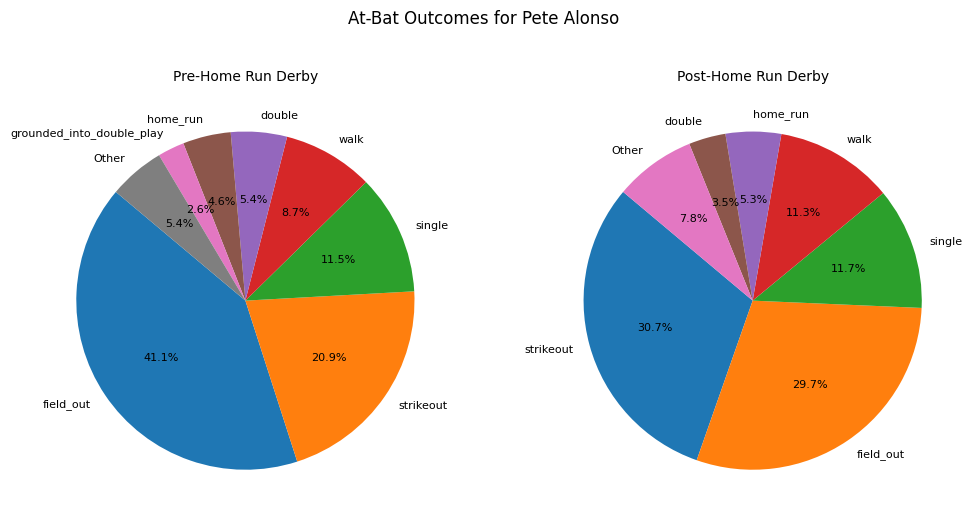

In [ ]:
# Visualize at-bat outcomes for Pete Alonso

events_pie(Alonso_pre, Alonso_post, 'Pete Alonso')

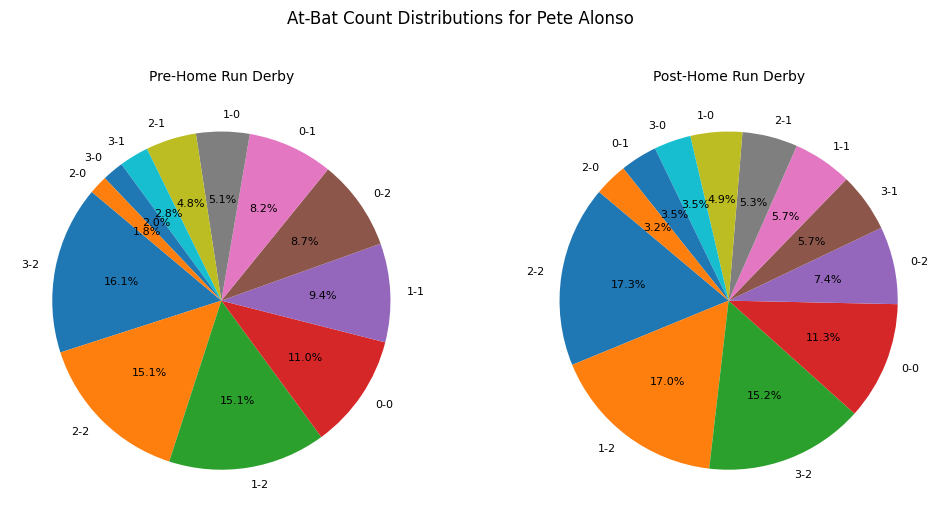

In [ ]:
# Visualize at-bat outcomes for Alonso pre-Break and post-Break

count_pie(Alonso_pre, Alonso_post, 'Pete Alonso')

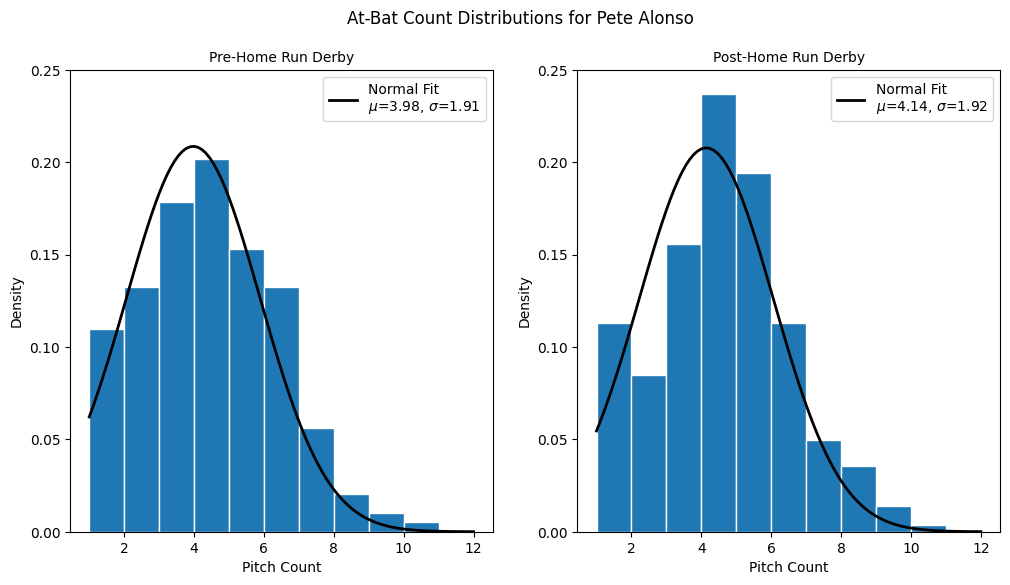

In [ ]:
# Visualize at-bat outcomes for Alonso pre-Break and post-Break

pitch_count_hist(Alonso_pre, Alonso_post, 'Pete Alonso')

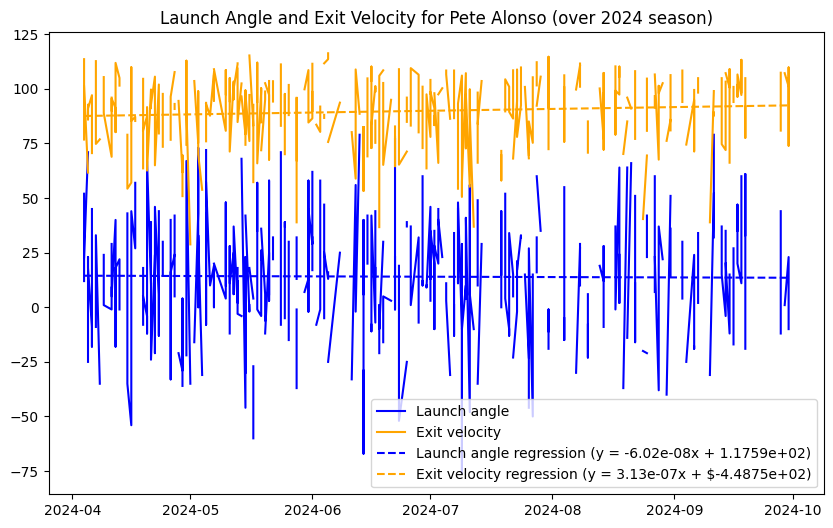

In [ ]:
# Visualize time-series graph of Pete Alonso's exit velocity and launch angle

ev_la_reg(Alonso, 'blue', 'orange', 'Pete Alonso')

### **Alec Bohm, Philadelphia Phillies**

In [ ]:
# Calculate number of at-bats per season half for Alec Bohm

print('Number of at-bats pre-Home Run Derby for Alec Bohm: ', len(Bohm_pre))
print('Number of at-bats post-Home Run Derby for Alec Bohm:', len(Bohm_post))
print('----------------------------------------------------------')

print('Bohm had', len(Bohm_pre) - len(Bohm_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Alec Bohm:  385
Number of at-bats post-Home Run Derby for Alec Bohm: 204
----------------------------------------------------------
Bohm had 181 more at-bats before the Home Run Derby


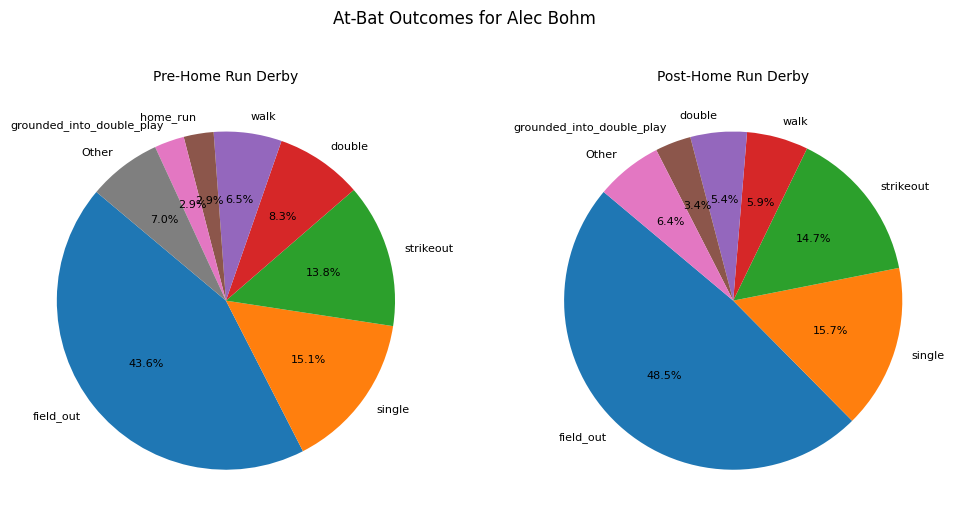

In [ ]:
# Visualize at-bat outcomes for Alec Bohm

events_pie(Bohm_pre, Bohm_post, 'Alec Bohm')

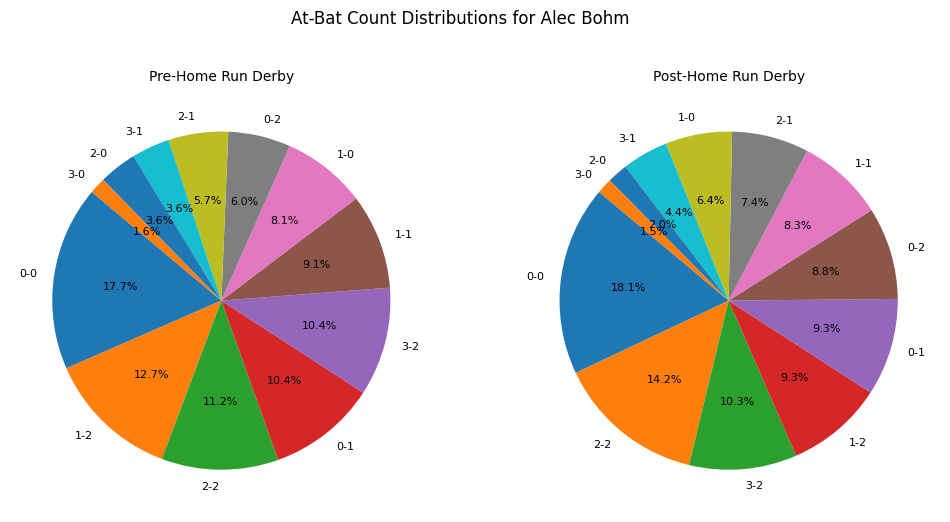

In [ ]:
# Visualize at-bat outcomes for Bohm pre-Break and post-Break

count_pie(Bohm_pre, Bohm_post, 'Alec Bohm')

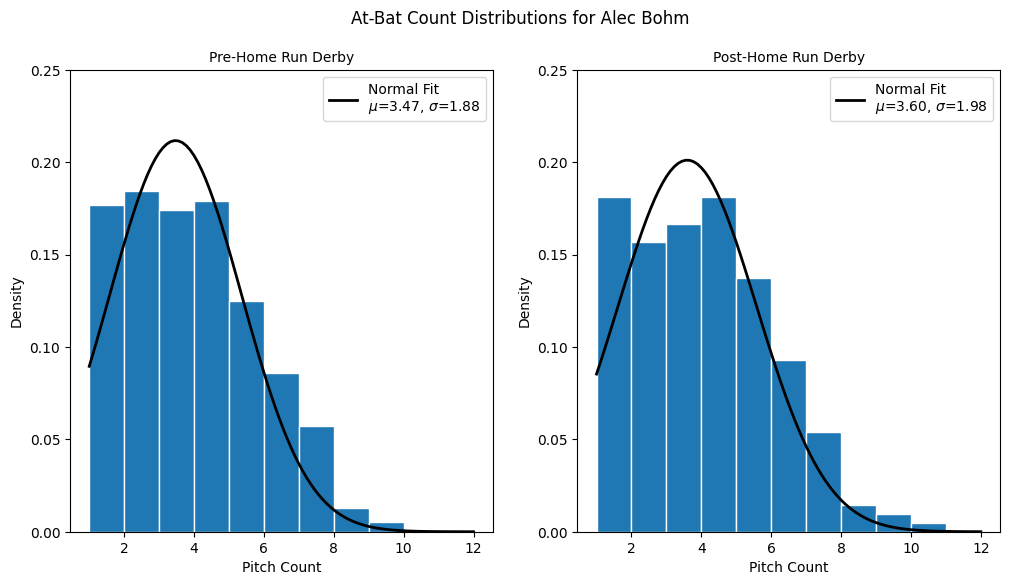

In [ ]:
# Visualize at-bat outcomes for Bohm pre-Break and post-Break

pitch_count_hist(Bohm_pre, Bohm_post, 'Alec Bohm')

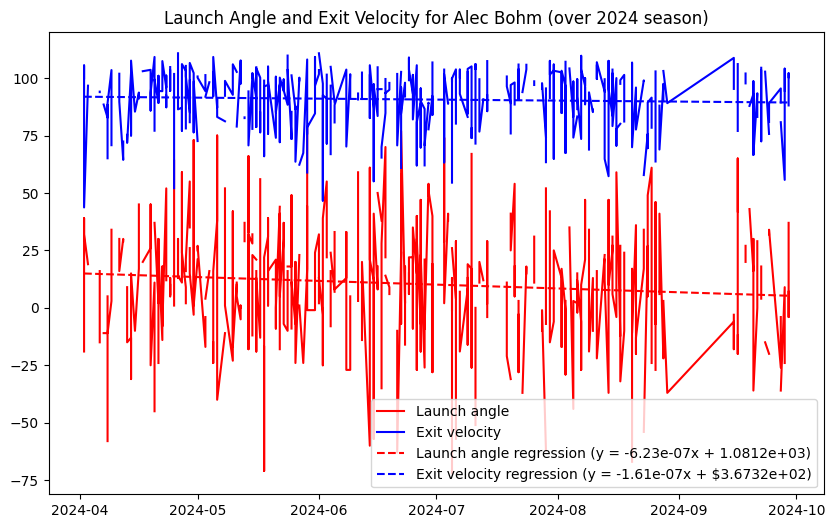

In [ ]:
# Visualize time-series graph of Alec Bohm's exit velocity and launch angle

ev_la_reg(Bohm, 'red', 'blue', 'Alec Bohm')

### **Adolis Garcia, Texas Rangers**

In [ ]:
# Calculate number of at-bats per season half for Adolis Garcia

print('Number of at-bats pre-Home Run Derby for Adolis Garcia: ', len(Garcia_pre))
print('Number of at-bats post-Home Run Derby for Adolis Garcia:', len(Garcia_post))
print('------------------------------------------------------------')

print('Garcia had', len(Garcia_pre) - len(Garcia_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Adolis Garcia:  358
Number of at-bats post-Home Run Derby for Adolis Garcia: 257
------------------------------------------------------------
Garcia had 101 more at-bats before the Home Run Derby


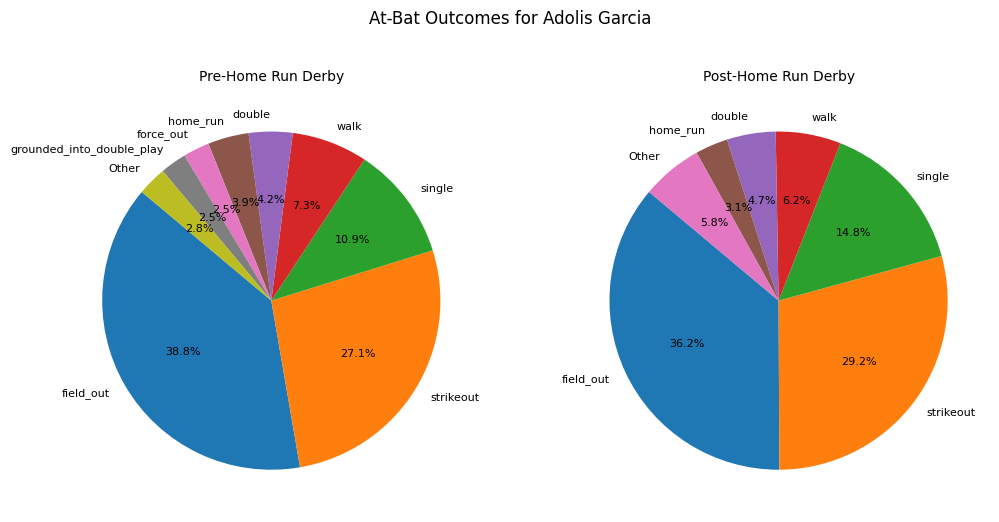

In [ ]:
# Visualize at-bat outcomes for Adolis Garcia

events_pie(Garcia_pre, Garcia_post, 'Adolis Garcia')

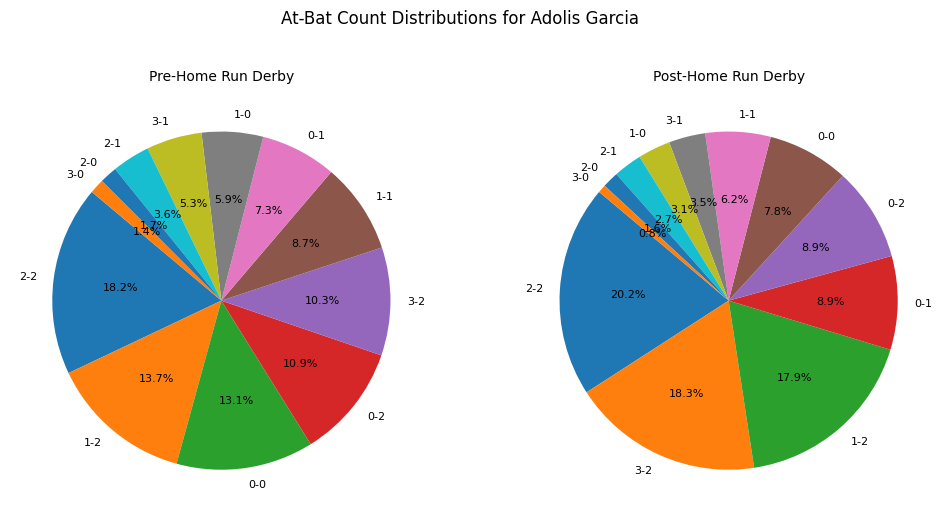

In [ ]:
# Visualize at-bat outcomes for Garcia pre-Break and post-Break

count_pie(Garcia_pre, Garcia_post, 'Adolis Garcia')

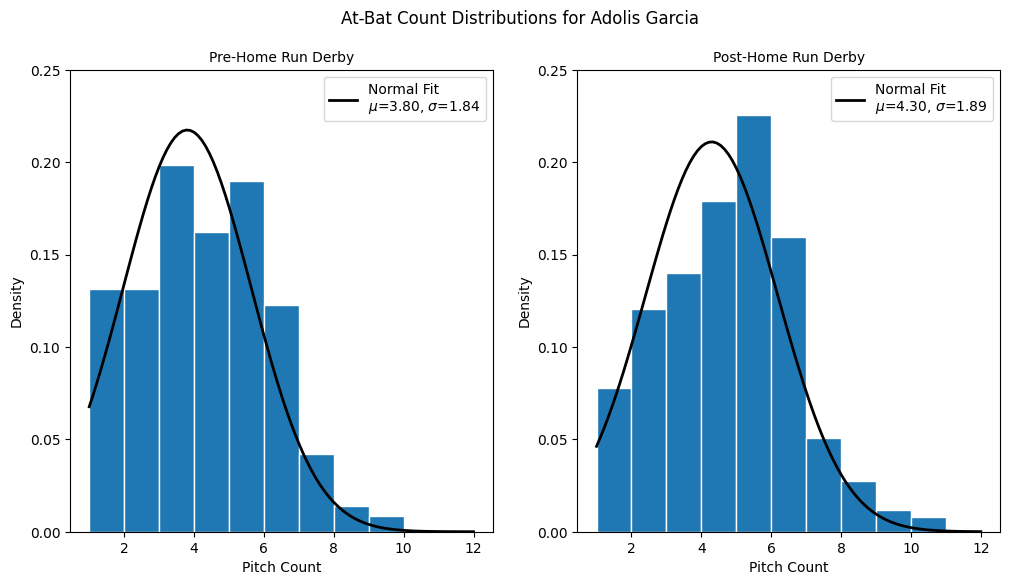

In [ ]:
# Visualize at-bat outcomes for Garcia pre-Break and post-Break

pitch_count_hist(Garcia_pre, Garcia_post, 'Adolis Garcia')

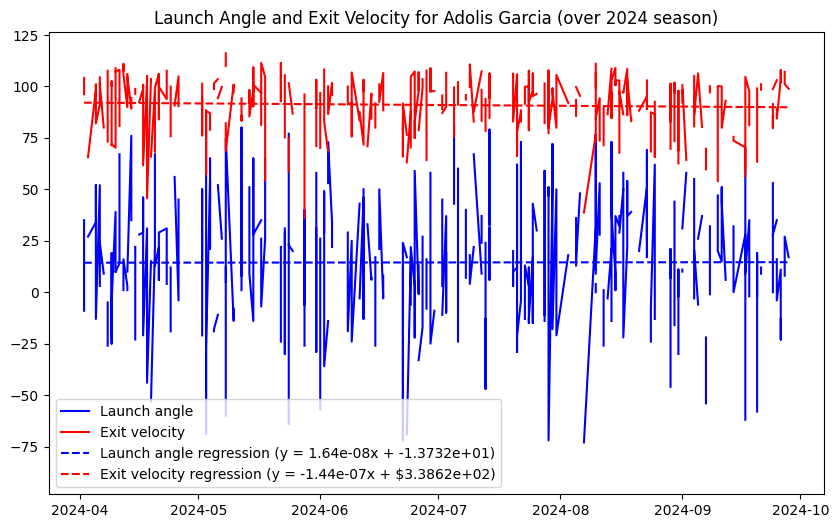

In [ ]:
# Visualize time-series graph of Adolis Garcia's exit velocity and launch angle

ev_la_reg(Garcia, 'blue', 'red', 'Adolis Garcia')

### **Gunnar Henderson, Baltimore Orioles**

In [ ]:
# Calculate number of at-bats per season half for Gunnar Henderson

print('Number of at-bats pre-Home Run Derby for Gunnar Henderson: ', len(Henderson_pre))
print('Number of at-bats post-Home Run Derby for Gunnar Henderson:', len(Henderson_post))
print('---------------------------------------------------------------')

print('Henderson had', len(Henderson_pre) - len(Henderson_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Gunnar Henderson:  413
Number of at-bats post-Home Run Derby for Gunnar Henderson: 286
---------------------------------------------------------------
Henderson had 127 more at-bats before the Home Run Derby


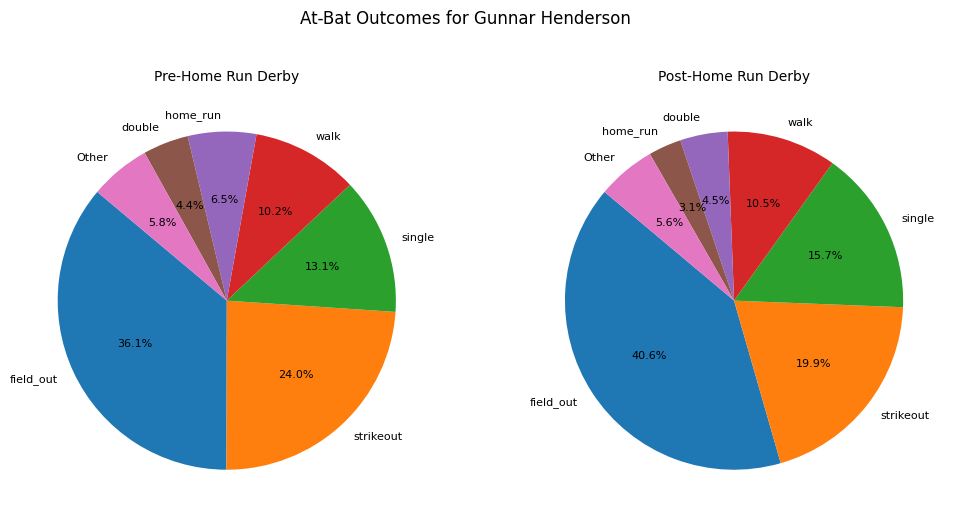

In [ ]:
# Visualize at-bat outcomes for Gunnar Henderson

events_pie(Henderson_pre, Henderson_post, 'Gunnar Henderson')

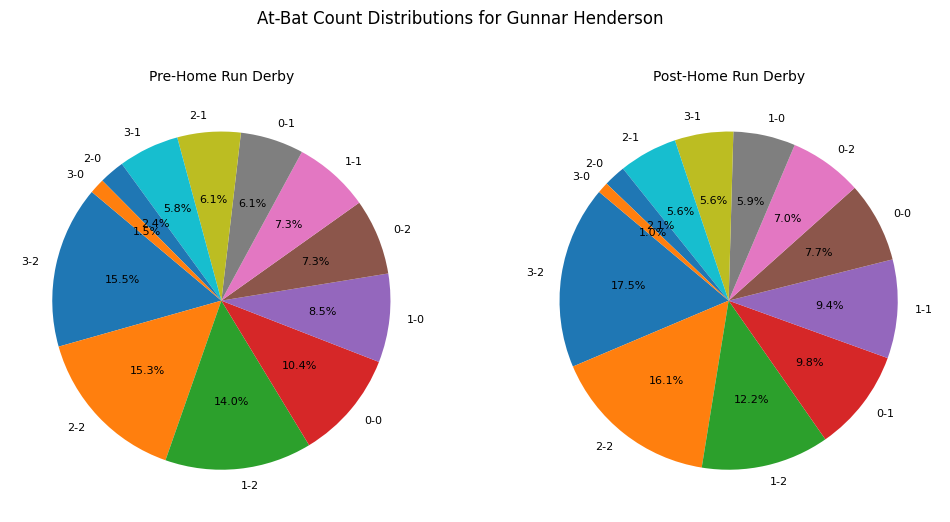

In [ ]:
# Visualize at-bat outcomes for Henderson pre-Break and post-Break

count_pie(Henderson_pre, Henderson_post, 'Gunnar Henderson')

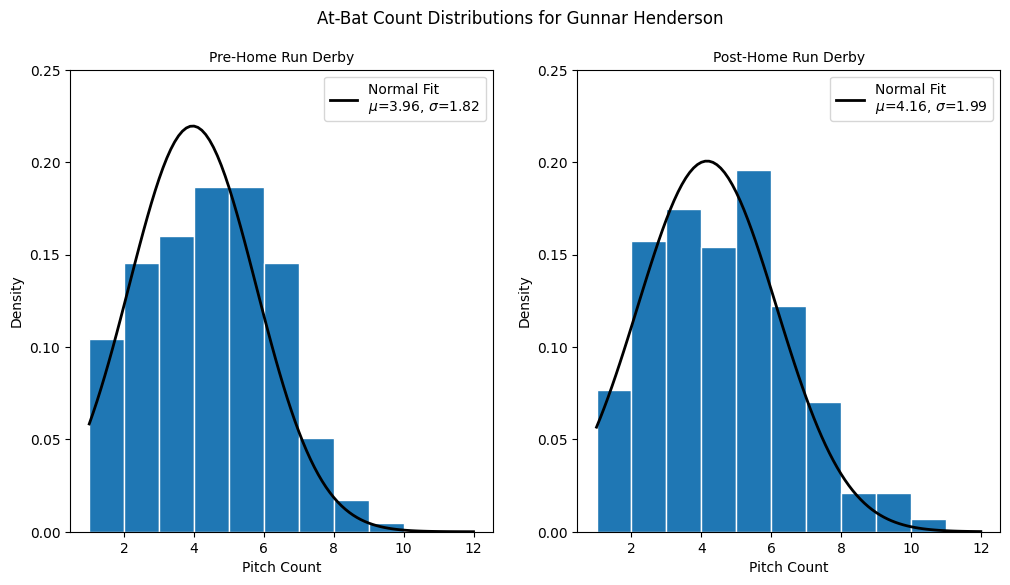

In [ ]:
# Visualize at-bat outcomes for Henderson pre-Break and post-Break

pitch_count_hist(Henderson_pre, Henderson_post, 'Gunnar Henderson')

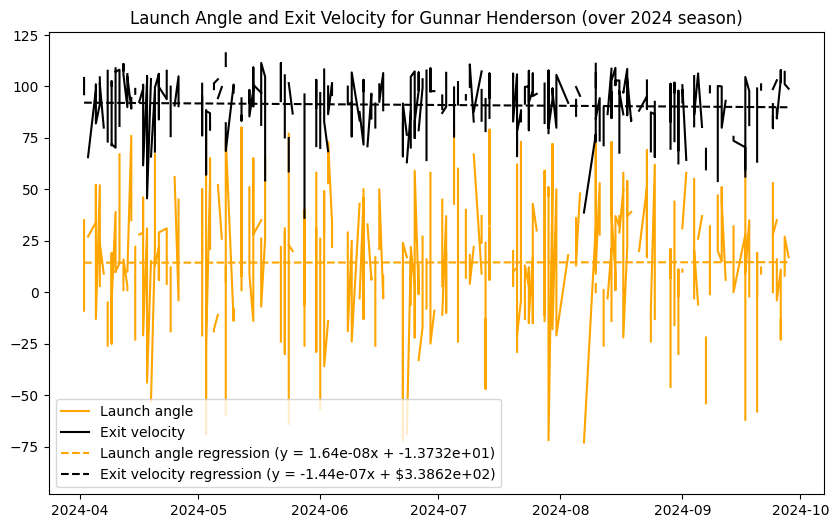

In [ ]:
# Visualize time-series graph of Gunnar Henderson's exit velocity and launch angle

ev_la_reg(Garcia, 'orange', 'black', 'Gunnar Henderson')

### **Teoscar Hernandez, Los Angeles Dodgers**

In [ ]:
# Calculate number of at-bats per season half for Teoscar Hernandez

print('Number of at-bats pre-Home Run Derby for Teoscar Hernandez: ', len(Hernandez_pre))
print('Number of at-bats post-Home Run Derby for Teoscar Hernandez:', len(Hernandez_post))
print('----------------------------------------------------------------')

print('Hernandez had', len(Hernandez_pre) - len(Hernandez_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Teoscar Hernandez:  371
Number of at-bats post-Home Run Derby for Teoscar Hernandez: 248
----------------------------------------------------------------
Hernandez had 123 more at-bats before the Home Run Derby


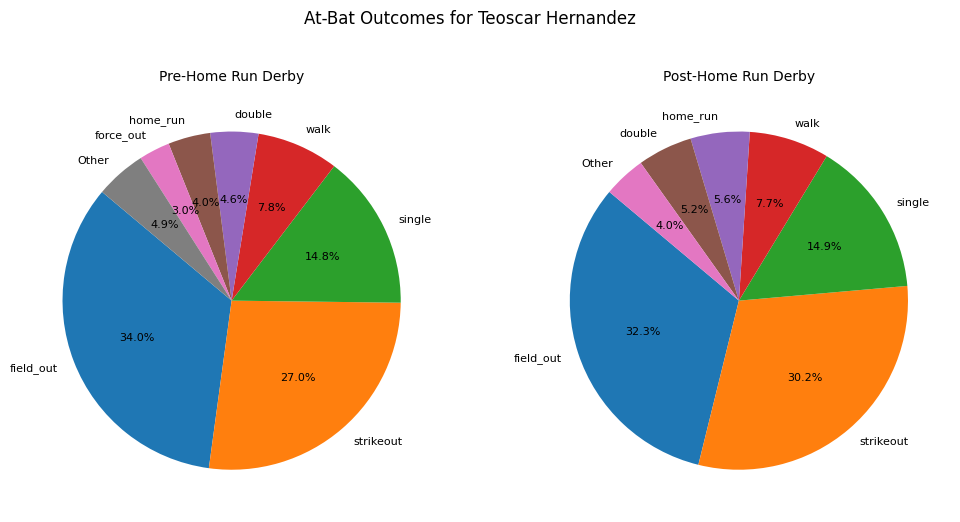

In [ ]:
# Visualize at-bat outcomes for Teoscar Hernandez

events_pie(Hernandez_pre, Hernandez_post, 'Teoscar Hernandez')

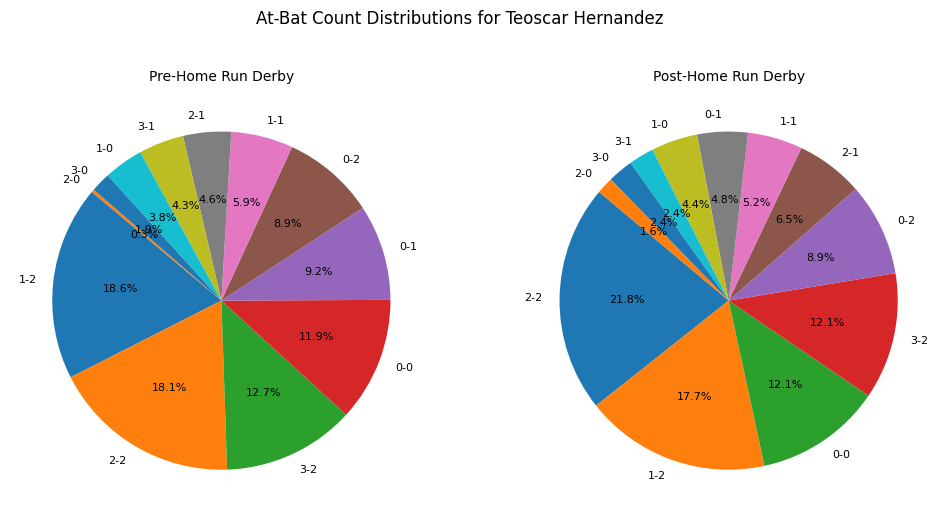

In [ ]:
# Visualize at-bat outcomes for Hernandez pre-Break and post-Break

count_pie(Hernandez_pre, Hernandez_post, 'Teoscar Hernandez')

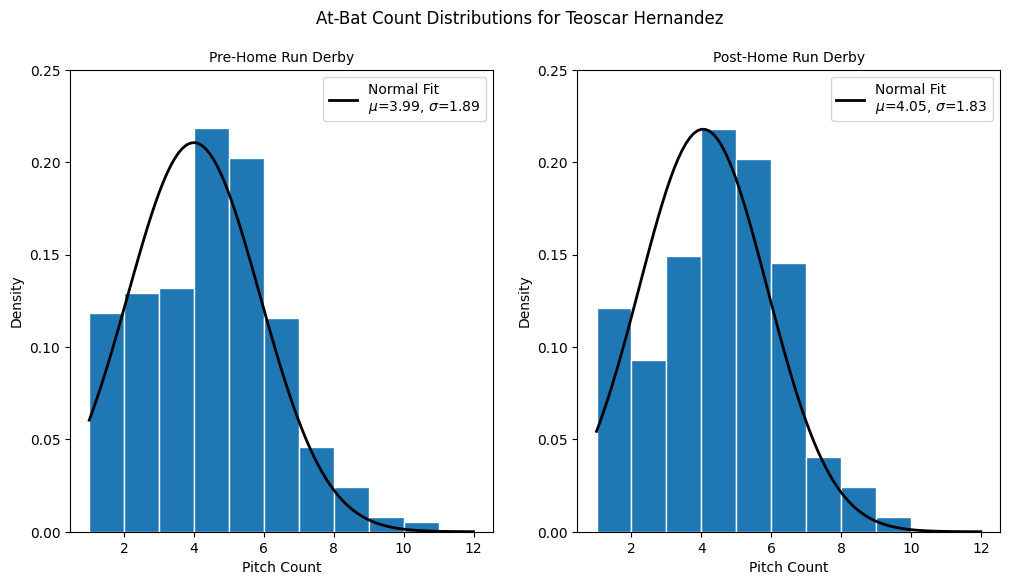

In [ ]:
# Visualize at-bat outcomes for Hernandez pre-Break and post-Break

pitch_count_hist(Hernandez_pre, Hernandez_post, 'Teoscar Hernandez')

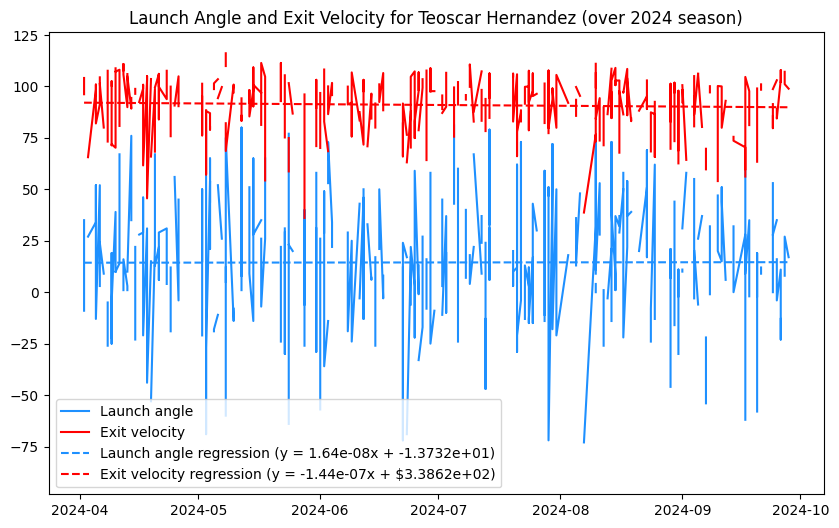

In [ ]:
# Visualize time-series graph of Teoscar Hernandez's exit velocity and launch angle

ev_la_reg(Garcia, 'dodgerblue', 'red', 'Teoscar Hernandez')

### **Marcell Ozuna, Atlanta Braves**

In [ ]:
# Calculate number of at-bats per season half for Marcell Ozuna

print('Number of at-bats pre-Home Run Derby for Marcell Ozuna: ', len(Ozuna_pre))
print('Number of at-bats post-Home Run Derby for Marcell Ozuna:', len(Ozuna_post))
print('------------------------------------------------------------')

print('Ozuna had', len(Ozuna_pre) - len(Ozuna_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Marcell Ozuna:  382
Number of at-bats post-Home Run Derby for Marcell Ozuna: 287
------------------------------------------------------------
Ozuna had 95 more at-bats before the Home Run Derby


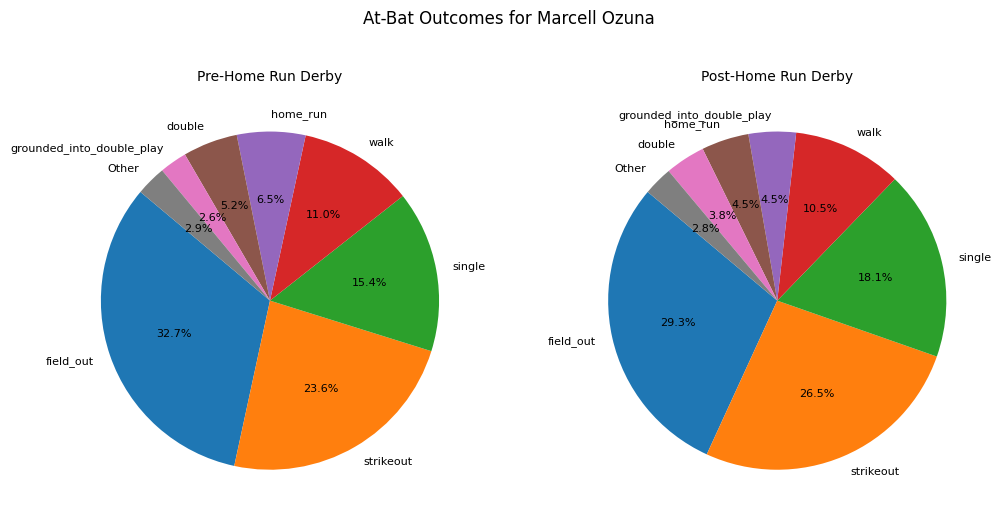

In [ ]:
# Visualize at-bat outcomes for Marcell Ozuna

events_pie(Ozuna_pre, Ozuna_post, 'Marcell Ozuna')

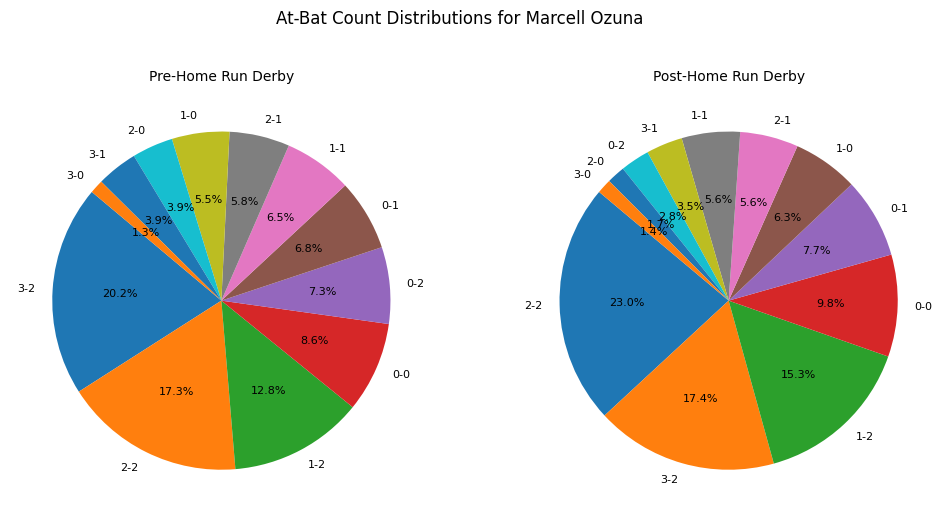

In [ ]:
# Visualize at-bat outcomes for Ozuna pre-Break and post-Break

count_pie(Ozuna_pre, Ozuna_post, 'Marcell Ozuna')

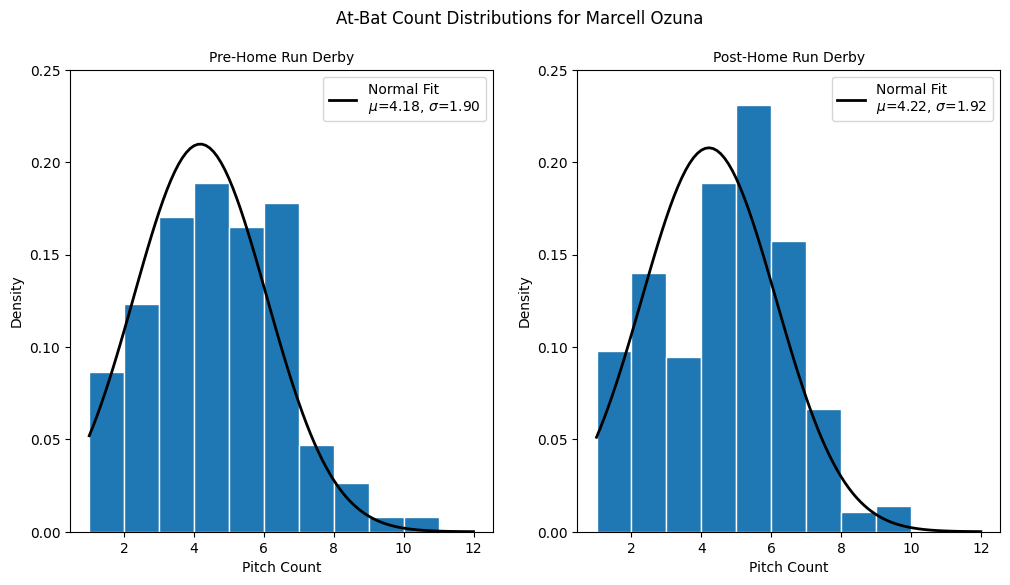

In [ ]:
# Visualize at-bat outcomes for Ozuna pre-Break and post-Break

pitch_count_hist(Ozuna_pre, Ozuna_post, 'Marcell Ozuna')

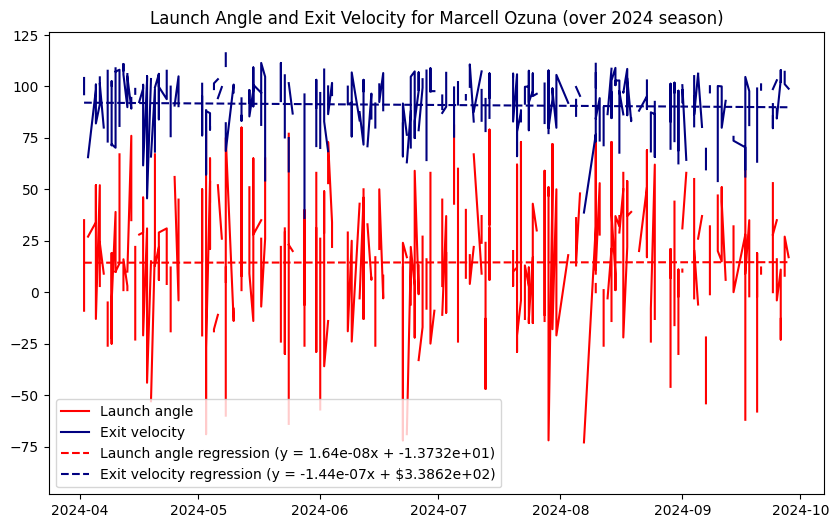

In [ ]:
# Visualize time-series graph of Marcell Ozuna's exit velocity and launch angle

ev_la_reg(Garcia, 'red', 'navy', 'Marcell Ozuna')

### **Jose Ramirez, Cleveland Guardians**

In [ ]:
# Calculate number of at-bats per season half for Jose Ramirez

print('Number of at-bats pre-Home Run Derby for Jose Ramirez: ', len(Ramirez_pre))
print('Number of at-bats post-Home Run Derby for Jose Ramirez:', len(Ramirez_post))
print('-----------------------------------------------------------')

print('Ramirez had', len(Ramirez_pre) - len(Ramirez_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Jose Ramirez:  370
Number of at-bats post-Home Run Derby for Jose Ramirez: 276
-----------------------------------------------------------
Ramirez had 94 more at-bats before the Home Run Derby


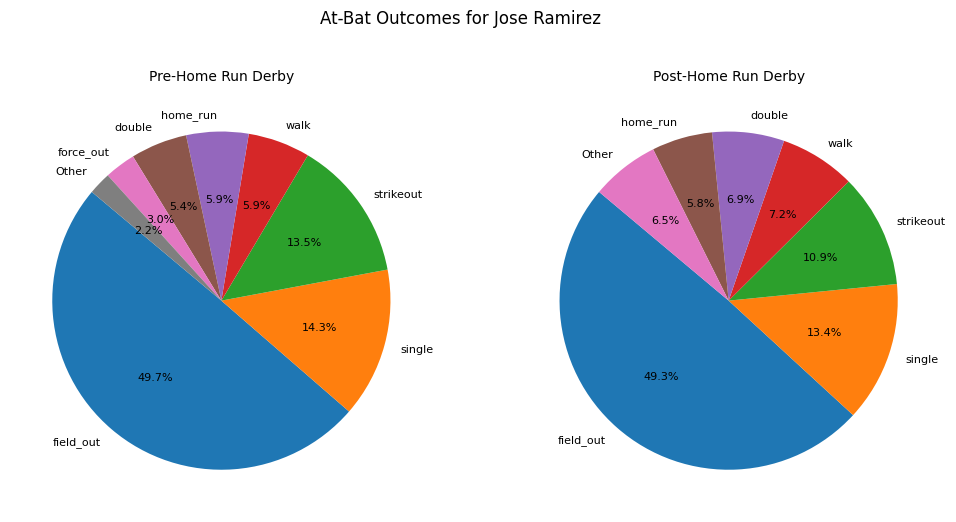

In [ ]:
# Visualize at-bat outcomes for Jose Ramirez

events_pie(Ramirez_pre, Ramirez_post, 'Jose Ramirez')

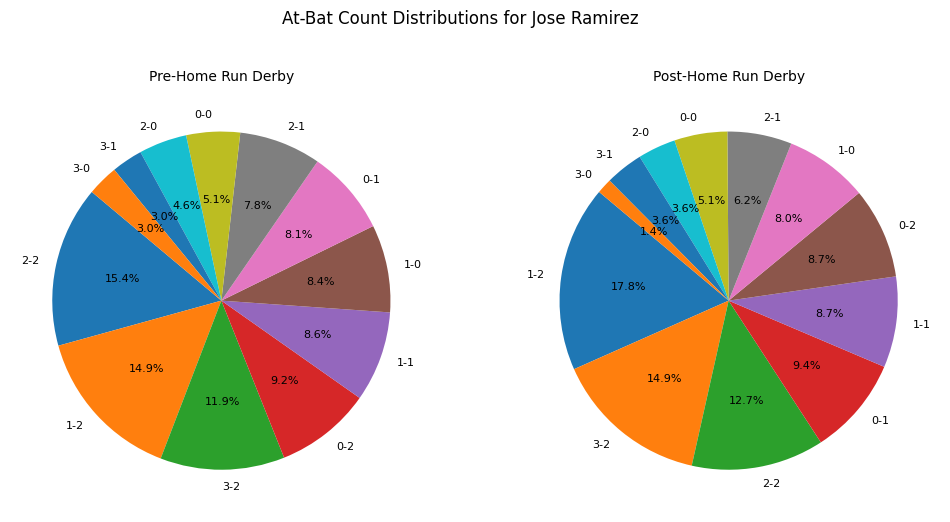

In [ ]:
# Visualize at-bat outcomes for Ramirez pre-Break and post-Break

count_pie(Ramirez_pre, Ramirez_post, 'Jose Ramirez')

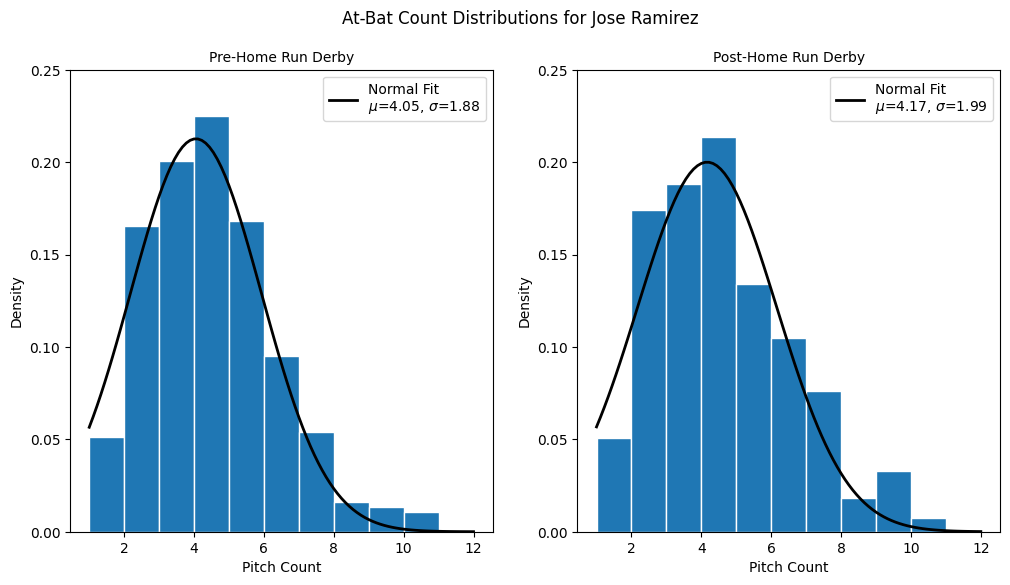

In [ ]:
# Visualize at-bat outcomes for Ramirez pre-Break and post-Break

pitch_count_hist(Ramirez_pre, Ramirez_post, 'Jose Ramirez')

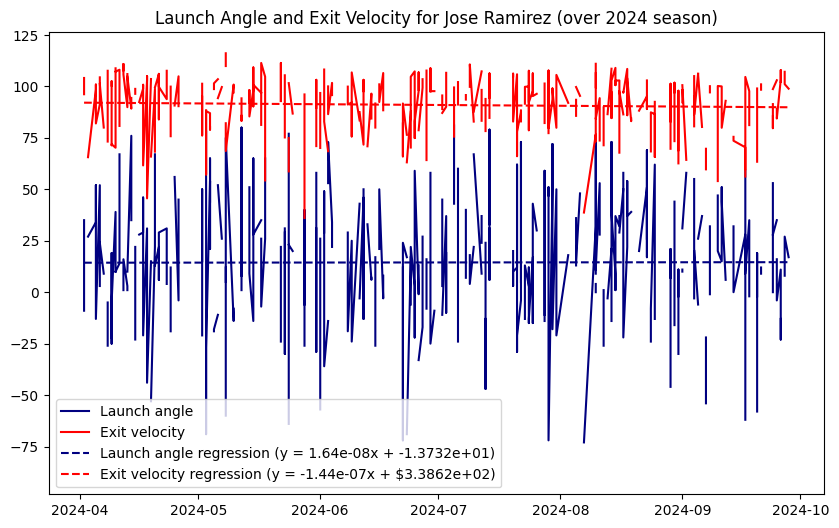

In [ ]:
# Visualize time-series graph of Jose Ramirez's exit velocity and launch angle

ev_la_reg(Garcia, 'navy', 'red', 'Jose Ramirez')

### **Bobby Witt Jr., Kansas City Royals**

In [ ]:
# Calculate number of at-bats per season half for Pete Alonso

print('Number of at-bats pre-Home Run Derby for Bobby Witt Jr.: ', len(Witt_pre))
print('Number of at-bats post-Home Run Derby for Bobby Witt Jr.:', len(Witt_post))
print('-------------------------------------------------------------')

print('Witt had', len(Witt_pre) - len(Witt_post), 'more at-bats before the Home Run Derby')

Number of at-bats pre-Home Run Derby for Bobby Witt Jr.:  403
Number of at-bats post-Home Run Derby for Bobby Witt Jr.: 280
-------------------------------------------------------------
Witt had 123 more at-bats before the Home Run Derby


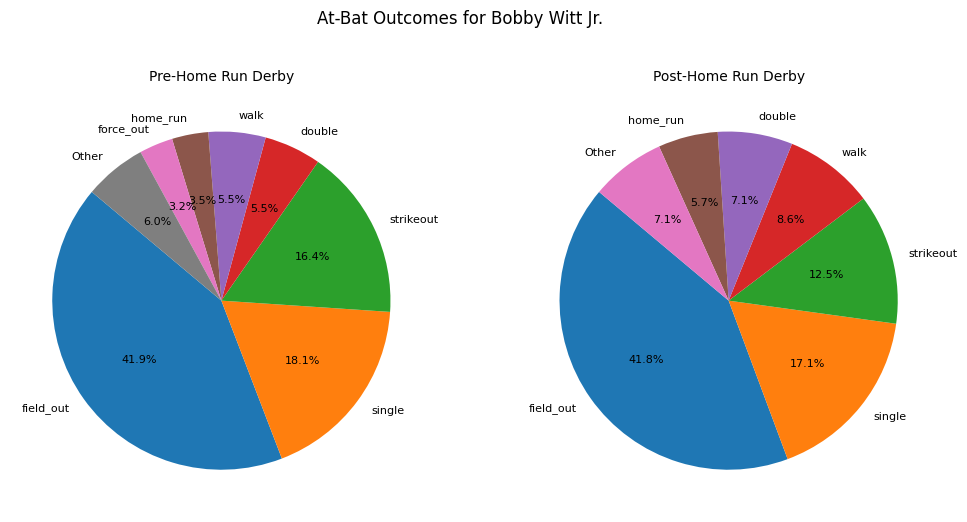

In [ ]:
# Visualize at-bat outcomes for Bobby Witt Jr.

events_pie(Witt_pre, Witt_post, 'Bobby Witt Jr.')

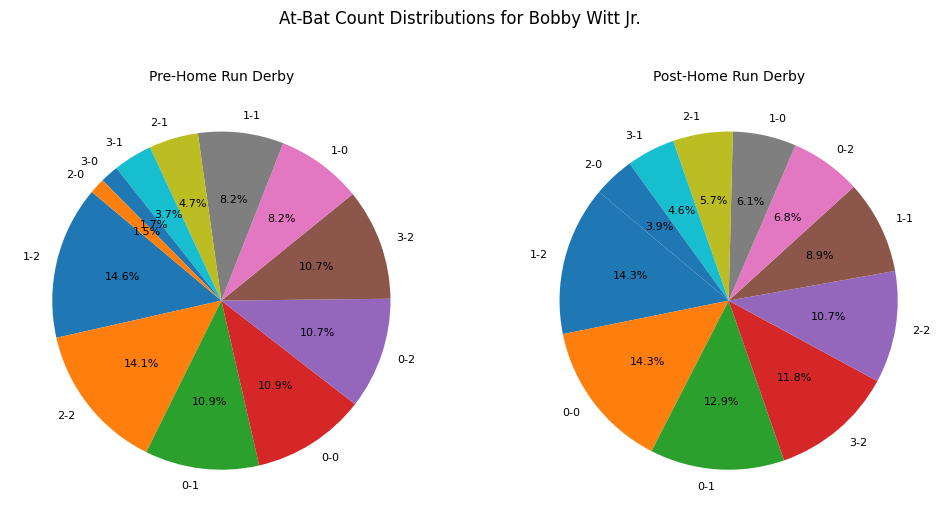

In [ ]:
# Visualize at-bat outcomes for Witt pre-Break and post-Break

count_pie(Witt_pre, Witt_post, 'Bobby Witt Jr.')

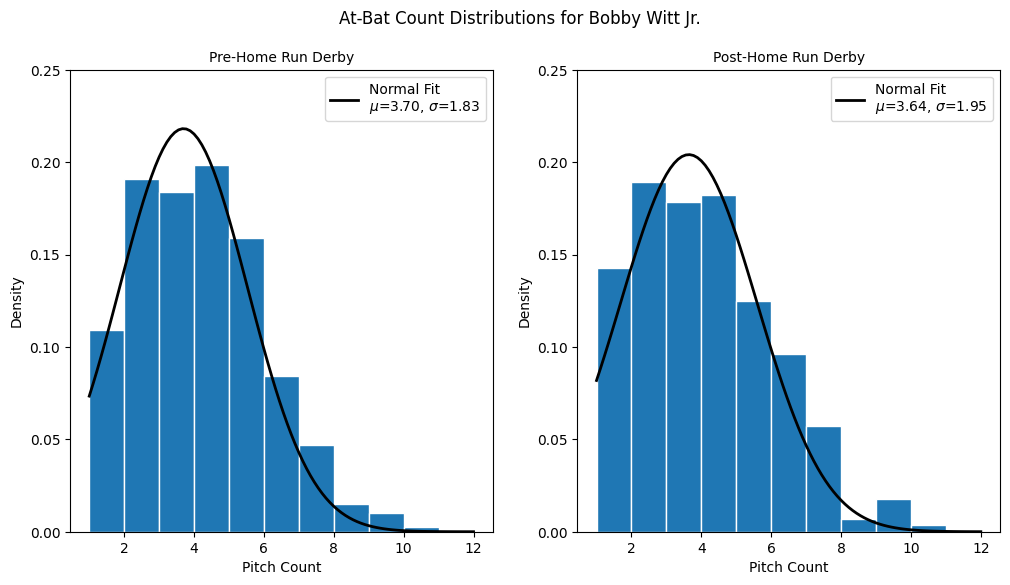

In [ ]:
# Visualize at-bat outcomes for Witt pre-Break and post-Break

pitch_count_hist(Witt_pre, Witt_post, 'Bobby Witt Jr.')

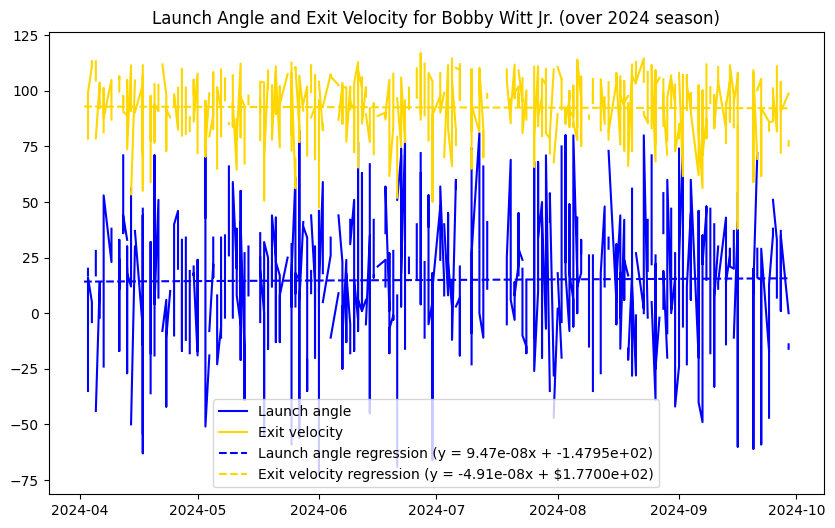

In [ ]:
# Visualize time-series graph of Bobby Witt Jr.'s exit velocity and launch angle

ev_la_reg(Witt, 'blue', 'gold', 'Bobby Witt Jr.')

### **Discussion**

When determining the PBPI for each of the eight batters, half appeared to improve after the All-Star break while the other half's performance worsened in the second half of the 2024 season. Collectively, the eight batters' performance only slightly weakened after the All-Star break with no significant change.

In looking at the overall trends, most batters tended to increase their walk rate and lower their strikeout rate, as this comparison alone could hint to improved plate discipline in the batters. To prove this hypothesis, normal distribution analysis was performed on the data of each batter's at-bat lengths, and it was concluded that in the second half of the season, the overall at-bat length trended upwards, with a higher sample mean $\mu$ and slightly lower but similar deviation $\sigma$.

Additionally, half of the batters' walk rates (BB%) increased after the home run derby while the other half saw a lower BB% after the All-Star break. Of the four batters with increased BB% in the second half of the season, two (Jose Ramirez and Bobby Witt Jr.) saw decreases in both strikeout rate (K%) and Six-Main Out rate (6MO%). In this case, the six main outs used to compute this metric, denoted `strikeout` and `field_out` in the dataset, are:

- Strikeout
- Groundout (part of `field_out`)
- Flyout (part of `field_out`)
- Lineout (part of `field_out`)
- Popout (part of `field_out`)
- Foulout (part of `field_out`)

Grounding into double plays and sacrifice hits are their own unique event in the dataset, as they are dependent on other base runners. The six outs are independent of any runners on the base path.

There were several quirks among the individual batters that should be made note of:

- Alec Bohm and Gunnar Henderson were most negatively impacted by the Home Run Derby, as their PBPIs were both less than -20. Inversely, Bobby Witt Jr. and Tesocar Hernandez had the greatest impact from the Home Run Derby with PBPI values exceeding 20.
- Adolis Garcia's PBPI was between 0 and -1, just as the overall PBPI value for all eight batters collectively, implying there wasn't much of a drastic change in Garcia's plate discipline and batting performance.
- Alec Bohm and Bobby Witt Jr. are the only 2024 Home Run Derby participants to record singles more often than striking out, in both halves of the season.
- Bobby Witt Jr. is the only 2024 Home Run Derby participant whose at-bats became shorter after the Home Run Derby. Additionally, he was the only batter who did not hit on a 3-0 count in the second half of the season, coinciding with a common belief in baseball to not swing and ultimately end an at-bat on a 3-0 count.

One more consideration from the data is the length of each half of the season. Every batter saw an increase in number of at-bats after the All-Star break, which either implies each batter saw more at-bats per game in even season halves, or the lengths of the season halves were unequal. The latter is true, as each team was scheduled 95 games before the All-Star break and 67 after.

**So, is the "Home Run Derby curse" a hoax?** In a word, yes.